In [1]:
# Gini3d_Within_Plume

import numpy as np
from numpy import ma
import math
import scipy
import scipy.constants as constants
import os
from IPython.display import Image

from netCDF4 import Dataset

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker

import pandas as pd
import datetime
from tqdm import tqdm
# from matplotlib.mlab import bivariate_normal

NA = 6.022e+23

In [2]:
# Lagrange: 2x2.5

FILEDIR0 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/Final_simulation_continuous_injection/gc_2x25_lagrange_final_V30_Dis10'

NcFile0   = Dataset(FILEDIR0+'/OutputDir/GEOSChem.SpeciesConc.20150101_0010z.nc4','r',format='NETCDF4_CLASSIC')
lat0             = NcFile0.variables['lat'][:]
lon0             = NcFile0.variables['lon'][:]
LA0              = NcFile0.variables['SpeciesConc_PASV_LA'][:,:,:,:]
LA0_3            = NcFile0.variables['SpeciesConc_PASV_LA3'][:,:,:,:]

LA0 = LA0 + LA0_3


NcFile00   = Dataset(FILEDIR0+'/OutputDir/GEOSChem.StateMet.20150101_0010z.nc4','r',format='NETCDF4_CLASSIC')
GC_V00 = NcFile00.variables['Met_AIRVOL'][:,:,:,:] # [m3]
GC_V00 = GC_V00*1e6 # [m3]=>[cm3]

GC_AD00 = NcFile00.variables['Met_AD'][:,:,:,:] # [kg]
GC_AD00 = GC_AD00*1000.0/28.97 # change [kg] to [mol]



# Eulerian: 2x2.5
FILEDIR3 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/Final_simulation_continuous_injection/gc_2x25_eulerian_final'

NcFile3   = Dataset(FILEDIR3+'/OutputDir/GEOSChem.SpeciesConc.20150101_0010z.nc4','r',format='NETCDF4_CLASSIC')
lat3             = NcFile3.variables['lat'][:]
lon3             = NcFile3.variables['lon'][:]
EU3              = NcFile3.variables['SpeciesConc_PASV_EU'][:,:,:,:]

NcFile33   = Dataset(FILEDIR3+'/OutputDir/GEOSChem.StateMet.20150101_0010z.nc4','r',format='NETCDF4_CLASSIC')
GC_V33 = NcFile33.variables['Met_AIRVOL'][:,:]
GC_V33 = GC_V33*1e6 # [m3]=>[cm3]

GC_AD33 = NcFile33.variables['Met_AD'][:,:,:,:] # [kg]
GC_AD33 = GC_AD33*1000.0/28.97 # change [kg] to [mol]


In [3]:
Nx = len(LA0[0,0,0,:])
Ny = len(LA0[0,0,:,0])
Nz = len(LA0[0,:,0,0])
Nt = len(LA0[:,0,0,0])

In [4]:
# 2 time step moving average for Met data
GC_V0 = GC_V00
GC_AD0 = GC_AD00

GC_V3 = GC_V33
GC_AD3 = GC_AD33

# for i in range(Nt):
#     GC_V0[i,:,:,:]  = (GC_V00[i,:,:,:]+GC_V00[i+1,:,:,:])/2
#     GC_AD0[i,:,:,:] = (GC_AD00[i,:,:,:]+GC_AD00[i+1,:,:,:])/2
    
#     GC_V3[i,:,:,:]  = (GC_V33[i,:,:,:]+GC_V33[i+1,:,:,:])/2
#     GC_AD3[i,:,:,:] = (GC_AD33[i,:,:,:]+GC_AD33[i+1,:,:,:])/2

In [5]:
LA0_mol = LA0[:,:,:,:]*GC_AD0[:,:,:,:] # [mol]
EU3_mol = EU3[:,:,:,:]*GC_AD3[:,:,:,:] # [mol]

LA0_C   = LA0_mol[:,:,:,:]/GC_V0[:,:,:,:] # [mol/cm3]
EU3_C   = EU3_mol[:,:,:,:]/GC_V3[:,:,:,:]

In [6]:
np.sum(EU3_mol[0,:,:,:])*98/1000 # [kg]

518300.489

In [7]:
Nt = 30
i_day = 29 # day 30

In [8]:
# (1) GEOS-Chem

# 3-D entropy

k = constants.k
print(f'Boltzmann constant={k}')


# entropy
Entropy3d_EU3 = []

for it in range(Nt):
    S_EU3 = -k*np.sum( GC_AD33[it,:,:,:]*EU3[it,:,:,:]* np.log(EU3[it,:,:,:], out=np.zeros_like(EU3[it,:,:,:]), \
                                                           where=(EU3[it,:,:,:]!=0)), axis=(0,1,2) )
   
    Entropy3d_EU3.append(S_EU3)

    
EU_tracer_mol = GC_AD33[i_day,:,:,:]*EU3[i_day,:,:,:]
EU_mixing_ratio = EU3[i_day,:,:,:]
    
print(Entropy3d_EU3, len(Entropy3d_EU3))

Boltzmann constant=1.380649e-23
[1.64397720156816e-15, 3.2712428067364802e-15, 4.92497777272512e-15, 6.5633004987008004e-15, 8.235209444510081e-15, 9.904893446842881e-15, 1.158954677698944e-14, 1.328486181006976e-14, 1.499349999554816e-14, 1.671859993518336e-14, 1.843547341581696e-14, 2.0201021732171522e-14, 2.1928173426672642e-14, 2.3680089325253122e-14, 2.5410344276898562e-14, 2.7151893600075522e-14, 2.8889894323966725e-14, 3.063458401613312e-14, 3.2395989943680003e-14, 3.4140914677532165e-14, 3.5920908337792e-14, 3.7661422063767044e-14, 3.945086687391744e-14, 4.1223932989754885e-14, 4.299669514190848e-14, 4.475317049574656e-14, 4.65112858396928e-14, 4.8290501918435846e-14, 5.0028135058337284e-14, 5.1775067366287366e-14] 30


In [9]:
# (2) PiG model: Instant Dilution in Post_process

# entropy
Entropy3d_LA0 = []

for it in range(Nt):
    S_LA0 = -k*np.sum( GC_AD00[it,:,:,:]*LA0[it,:,:,:]* np.log(LA0[it,:,:,:], out=np.zeros_like(LA0[it,:,:,:]), \
                                                           where=(LA0[it,:,:,:]!=0)), axis=(0,1,2) )
  
    Entropy3d_LA0.append(S_LA0)

PG_tracer_mol = GC_AD00[i_day,:,:,:]*LA0[i_day,:,:,:]
PG_mixing_ratio = LA0[i_day,:,:,:]
    
print(Entropy3d_LA0, len(Entropy3d_LA0))

[1.58874671303944e-15, 3.1710222689899204e-15, 4.76303316762112e-15, 6.36962924228832e-15, 7.99873718548224e-15, 9.61531590467904e-15, 1.12249458726848e-14, 1.2927868834014722e-14, 1.456756734910592e-14, 1.624613787111424e-14, 1.791230950239104e-14, 1.9587455131264002e-14, 2.1286472512702722e-14, 2.302486202735232e-14, 2.477523690074496e-14, 2.6473273469134082e-14, 2.8172377444878082e-14, 2.9882881825996804e-14, 3.158783180096256e-14, 3.3317289731553284e-14, 3.5026272527022085e-14, 3.674385820163584e-14, 3.8468724866816e-14, 4.021340218836736e-14, 4.193463189272576e-14, 4.3642257455001605e-14, 4.5395979463377924e-14, 4.7141833760588805e-14, 4.8894470689303046e-14, 5.0591962950630404e-14] 30


In [10]:
# (3) PiG model: No Instant Dilution in Post_process

# entropy
# Entropy3d_LA1 = []

date1 = datetime.date(2015, 1, 1)
delta = datetime.timedelta(days=1)

df00 = pd.read_fwf(FILEDIR0+'/Plume_entropy.txt', header=None)
    

Entropy3d_LA1 = df00.iloc[:,2]

print(Entropy3d_LA1, len(Entropy3d_LA1))

0     8.194784e-18
1     1.315225e-15
2     2.757278e-15
3     4.158234e-15
4     5.716875e-15
5     7.278293e-15
6     8.697245e-15
7     1.029374e-14
8     1.198243e-14
9     1.353723e-14
10    1.504790e-14
11    1.652908e-14
12    1.811014e-14
13    1.989736e-14
14    2.156573e-14
15    2.326266e-14
16    2.486398e-14
17    2.649725e-14
18    2.811469e-14
19    2.981716e-14
20    3.156080e-14
21    3.308778e-14
22    3.471819e-14
23    3.655678e-14
24    3.824382e-14
25    3.977748e-14
26    4.156864e-14
27    4.321908e-14
28    4.510714e-14
29    4.671651e-14
30    4.828217e-14
31    4.994881e-14
Name: 2, dtype: float64 32


In [11]:
Entropy3d_LA1

0     8.194784e-18
1     1.315225e-15
2     2.757278e-15
3     4.158234e-15
4     5.716875e-15
5     7.278293e-15
6     8.697245e-15
7     1.029374e-14
8     1.198243e-14
9     1.353723e-14
10    1.504790e-14
11    1.652908e-14
12    1.811014e-14
13    1.989736e-14
14    2.156573e-14
15    2.326266e-14
16    2.486398e-14
17    2.649725e-14
18    2.811469e-14
19    2.981716e-14
20    3.156080e-14
21    3.308778e-14
22    3.471819e-14
23    3.655678e-14
24    3.824382e-14
25    3.977748e-14
26    4.156864e-14
27    4.321908e-14
28    4.510714e-14
29    4.671651e-14
30    4.828217e-14
31    4.994881e-14
Name: 2, dtype: float64

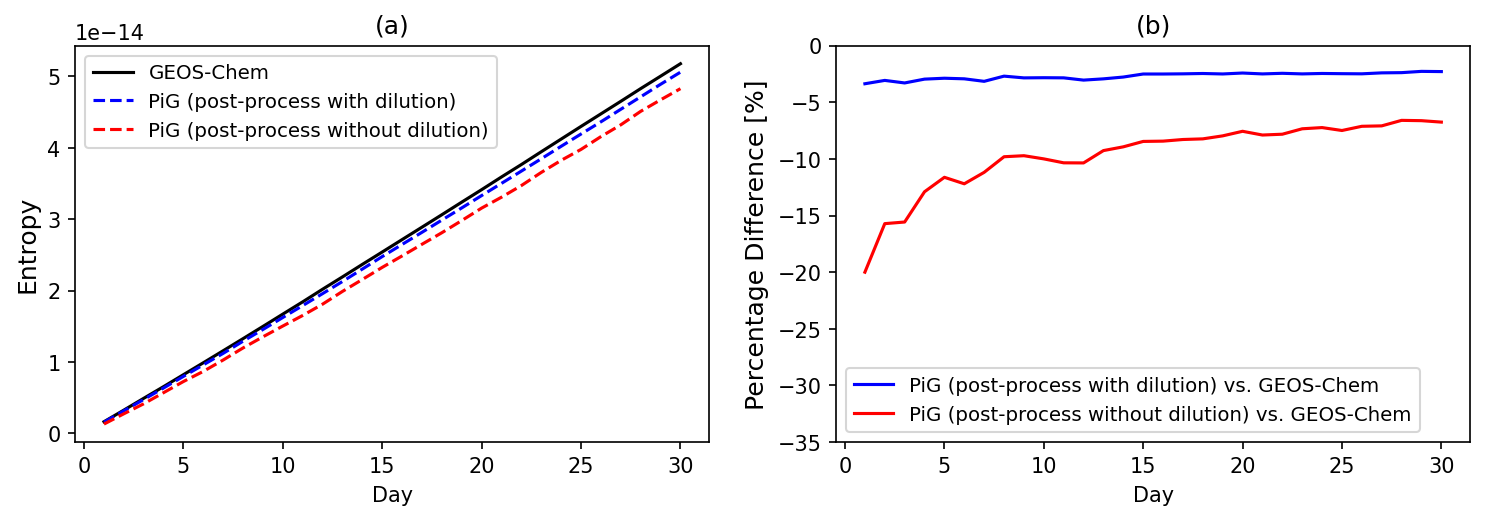

In [12]:
Nt1 = 1
Nt2 = 31

days = np.arange(Nt1,Nt2,1)

fig = plt.figure(figsize=(12,3.5), dpi=150)

# first
ax1 = fig.add_subplot(1,2,1)
ax1.plot(days, Entropy3d_EU3[Nt1-1:Nt2-1],'k', label='GEOS-Chem')
ax1.plot(days, Entropy3d_LA0[Nt1-1:Nt2-1],'b--', label='PiG (post-process with dilution)')
ax1.plot(days, Entropy3d_LA1[Nt1:Nt2],'r--', label='PiG (post-process without dilution)')

# plt.yscale('log')

ax1.set_ylabel('Entropy', fontsize=12)
ax1.set_xlabel('Day')
ax1.set_title('(a)', loc='center')
ax1.legend(prop={"size":9.5});


# second
ax2 = fig.add_subplot(1,2,2)

Entropy3d_EU3 = np.array(Entropy3d_EU3)
Entropy3d_LA0 = np.array(Entropy3d_LA0)
Entropy3d_LA1 = np.array(Entropy3d_LA1)

Percent1 = 100*(Entropy3d_LA0[Nt1-1:Nt2-1]-Entropy3d_EU3[Nt1-1:Nt2-1])/Entropy3d_EU3[Nt1-1:Nt2-1]
Percent2 = 100*(Entropy3d_LA1[Nt1:Nt2]-Entropy3d_EU3[Nt1-1:Nt2-1])/Entropy3d_EU3[Nt1-1:Nt2-1]

ax2.plot(days, Percent1,'b', label='PiG (post-process with dilution) vs. GEOS-Chem')
ax2.plot(days, Percent2,'r', label='PiG (post-process without dilution) vs. GEOS-Chem')

# plt.yscale('log')
ax2.set_ylim(-35,0)
ax2.set_ylabel('Percentage Difference [%]', fontsize=12)
ax2.set_xlabel('Day')
ax2.set_title('(b)', loc='center')
ax2.legend(loc='lower left', prop={"size":9.5});

In [13]:
Dir = '/n/home12/hongwei/HONGWEI/GC_run_13.0/Final_simulation_continuous_injection/gc_2x25_lagrange_final_V30_Dis10_entropy_check'
file1_name = Dir+'/Plume_entropy_check.txt'
    
    
df_old = pd.read_fwf(file1_name, header=None, sep=" ")
df_old.columns = ['Type', "tracer_mol","mixing_ratio"] # [molec/cm3], [cm3]

# df_old["tracer_mol","mixing_ratio"].astype('float32')

df_old[["tracer_mol","mixing_ratio"]] = df_old[["tracer_mol","mixing_ratio"]].astype('float32')
df = df_old
# df = df_old[df_old['mixing_ratio']>1.175494e-38]

LA_tracer_mol   = df["tracer_mol"]
LA_mixing_ratio = df['mixing_ratio']
LA_type         = df['Type']


EU_tracer_mol   = EU_tracer_mol.reshape(-1)
EU_mixing_ratio = EU_mixing_ratio.reshape(-1)

PG_tracer_mol   = PG_tracer_mol.reshape(-1)
PG_mixing_ratio = PG_mixing_ratio.reshape(-1)

In [14]:
LA_air_mass  = LA_tracer_mol /LA_mixing_ratio
EU_air_mass  = EU_tracer_mol /EU_mixing_ratio
PG_air_mass  = PG_tracer_mol /PG_mixing_ratio

In [15]:
EU_index = EU_mixing_ratio.argsort()
EU_mixing_ratio_sorted = EU_mixing_ratio[EU_index]
EU_tracer_mol_sorted = EU_tracer_mol[EU_index]
EU_tracer_mol_cumsum = np.cumsum(EU_tracer_mol_sorted)

PG_index = PG_mixing_ratio.argsort()
PG_mixing_ratio_sorted = PG_mixing_ratio[PG_index]
PG_tracer_mol_sorted = PG_tracer_mol[PG_index]
PG_tracer_mol_cumsum = np.cumsum(PG_tracer_mol_sorted)

LA_index = LA_mixing_ratio.argsort()
LA_mixing_ratio_sorted = LA_mixing_ratio[LA_index]
LA_tracer_mol_sorted = LA_tracer_mol[LA_index]
LA_tracer_mol_cumsum = np.cumsum(LA_tracer_mol_sorted)
LA_type_sorted = LA_type[LA_index]

In [16]:
LA_tracer_mol_cumsum[-2:-1]

2590501    157975792.0
Name: tracer_mol, dtype: float32

-367316.0
-342412.0
2.9524308e-10
[-200.]
[168.]
4.90866e-08


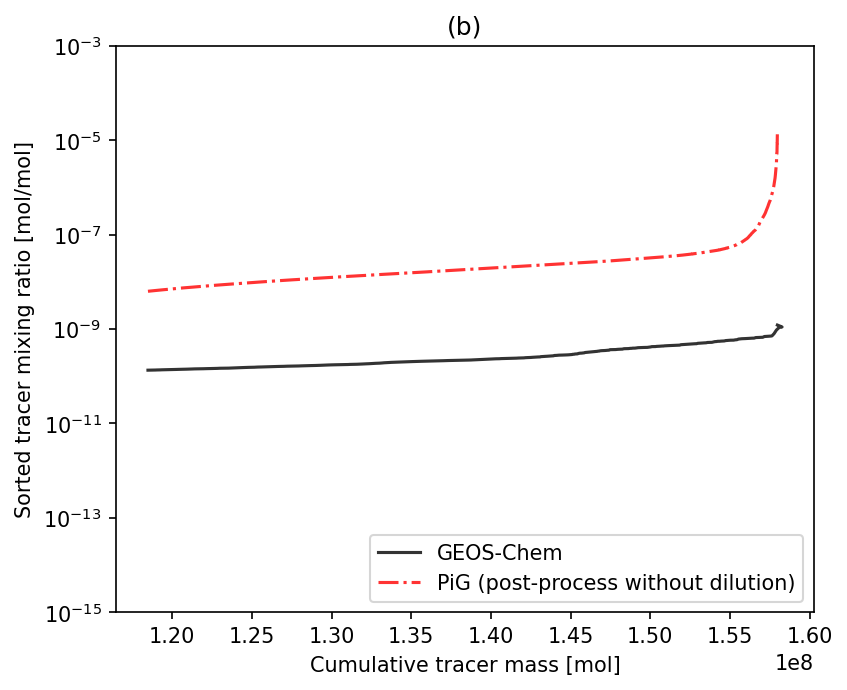

In [17]:
EU_num1 = -991
EU_mixing_new = EU_mixing_ratio_sorted[EU_num1:-1]
EU_tracer_new = EU_tracer_mol_sorted[EU_num1:-1]
EU_tracer_cumsum_new = EU_tracer_mol_cumsum[EU_num1:-1]

print(EU_tracer_cumsum_new[0]-0.75*EU_tracer_cumsum_new[-1])
print(EU_tracer_cumsum_new[1]-0.75*EU_tracer_cumsum_new[-1])

print( np.sum(EU_mixing_new*EU_tracer_new)/np.sum(EU_tracer_new) )

# PG_num1 = -19500
# PG_mixing_new = PG_mixing_ratio_sorted[PG_num1:-1]
# PG_tracer_new = PG_tracer_mol_sorted[PG_num1:-1]
# PG_tracer_cumsum_new = PG_tracer_mol_cumsum[PG_num1:-1]

LA_num1 = -245596
LA_mixing_new = LA_mixing_ratio_sorted[LA_num1:-1]
LA_tracer_new = LA_tracer_mol_sorted[LA_num1:-1]
LA_tracer_cumsum_new = LA_tracer_mol_cumsum[LA_num1:-1]



EU_tracer_cumsum_new[-1] = LA_tracer_cumsum_new.values[-1]
# PG_tracer_cumsum_new[-1] = LA_tracer_cumsum_new.values[-1]

print(LA_tracer_cumsum_new[0:1].values - 0.75*LA_tracer_cumsum_new[-2:-1].values)
print(LA_tracer_cumsum_new[1:2].values - 0.75*LA_tracer_cumsum_new[-2:-1].values)

print( np.sum(LA_mixing_new*LA_tracer_new)/np.sum(LA_tracer_new) )



figure = plt.figure(figsize=(6,5), dpi=150)

a = 0.8

plt.plot(EU_tracer_cumsum_new, EU_mixing_new, 'k-', alpha=a, label='GEOS-Chem')

# plt.plot(PG_tracer_cumsum_new, PG_mixing_new, 'b--', alpha=a, label='PiG (post-process with dilution)')

plt.plot(LA_tracer_cumsum_new, LA_mixing_new, 'r-.', alpha=a, label='PiG (post-process without dilution)')


plt.xlabel('Cumulative tracer mass [mol]')
plt.ylabel('Sorted tracer mixing ratio [mol/mol]')
plt.title('(b)')

# plt.xlim(1, 1e8)
plt.ylim(1e-15, 1e-3)

plt.yscale('log')
# plt.xscale('log')

plt.legend(loc='lower right');

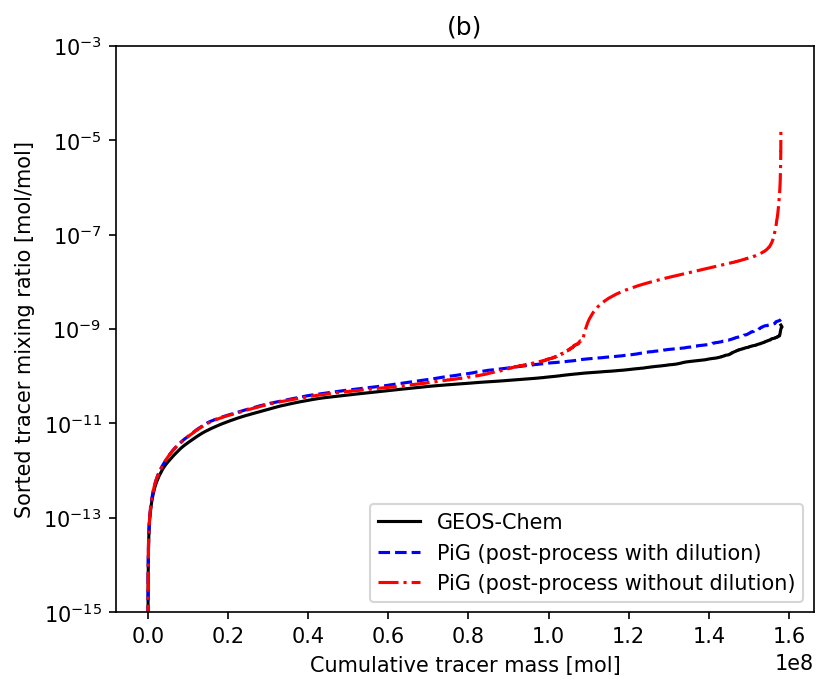

In [18]:
EU_num1 = -195000
EU_mixing_new = EU_mixing_ratio_sorted[EU_num1:-1]
EU_tracer_new = EU_tracer_mol_sorted[EU_num1:-1]
EU_tracer_cumsum_new = EU_tracer_mol_cumsum[EU_num1:-1]

PG_num1 = -195000
PG_mixing_new = PG_mixing_ratio_sorted[PG_num1:-1]
PG_tracer_new = PG_tracer_mol_sorted[PG_num1:-1]
PG_tracer_cumsum_new = PG_tracer_mol_cumsum[PG_num1:-1]

LA_num1 = -3500000
LA_mixing_new = LA_mixing_ratio_sorted[LA_num1:-1]
LA_tracer_new = LA_tracer_mol_sorted[LA_num1:-1]
LA_tracer_cumsum_new = LA_tracer_mol_cumsum[LA_num1:-1]



EU_tracer_cumsum_new[-1] = LA_tracer_cumsum_new.values[-1]
PG_tracer_cumsum_new[-1] = LA_tracer_cumsum_new.values[-1]


figure = plt.figure(figsize=(6,5), dpi=150)

a = 1

plt.plot(EU_tracer_cumsum_new, EU_mixing_new, 'k-', alpha=a, label='GEOS-Chem')

plt.plot(PG_tracer_cumsum_new, PG_mixing_new, 'b--', alpha=a, label='PiG (post-process with dilution)')

plt.plot(LA_tracer_cumsum_new, LA_mixing_new, 'r-.', alpha=a, label='PiG (post-process without dilution)')


plt.xlabel('Cumulative tracer mass [mol]')
plt.ylabel('Sorted tracer mixing ratio [mol/mol]')
plt.title('(b)')

# plt.xlim(1, 1e8)
plt.ylim(1e-15, 1e-3)

plt.yscale('log')
# plt.xscale('log')

plt.legend(loc='lower right');

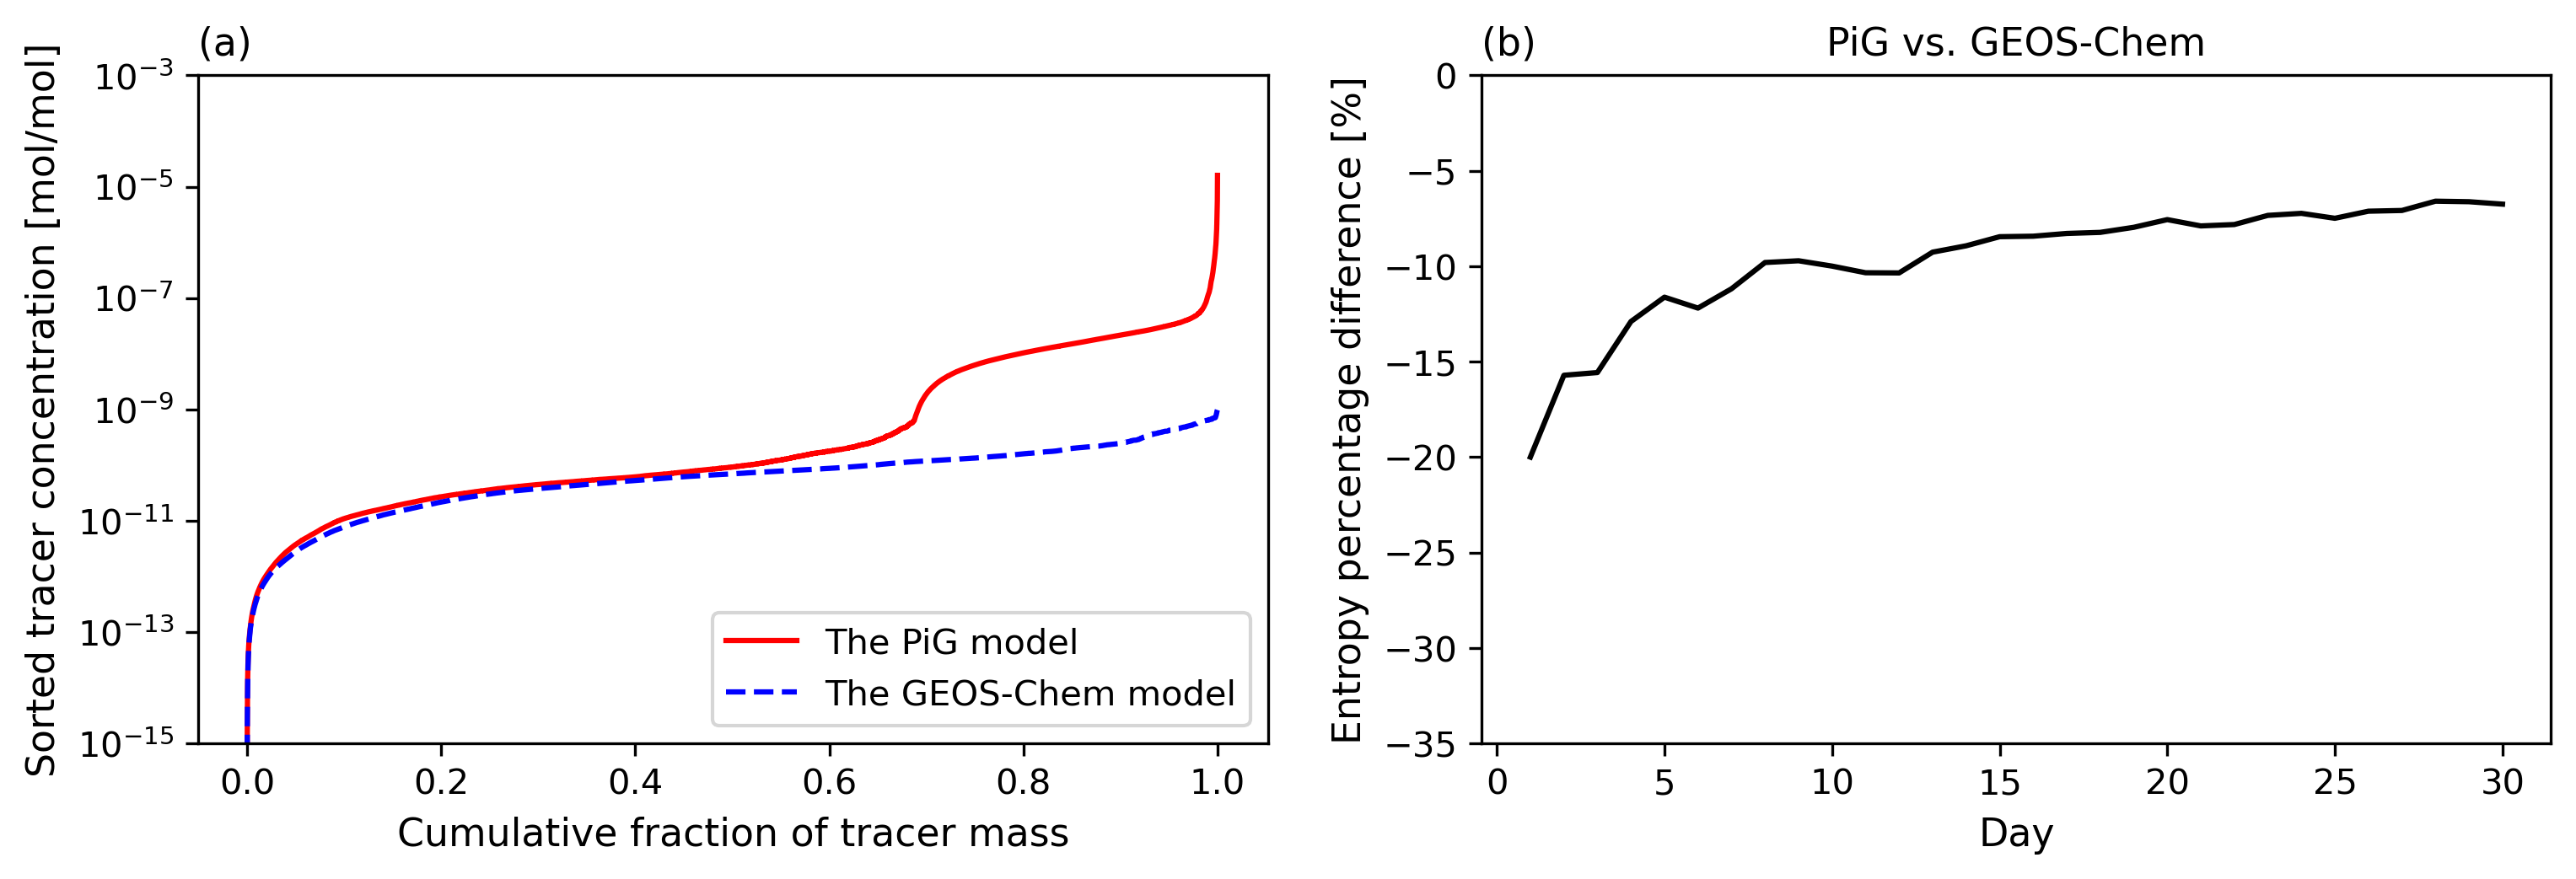

In [19]:
Nt1 = 1
Nt2 = 31

days = np.arange(Nt1,Nt2,1)

fig = plt.figure(figsize=(12,3.5), dpi=300)

# first
ax1 = fig.add_subplot(1,2,1)

# ax1.plot(PG_tracer_cumsum_new, PG_mixing_new, 'b--', alpha=a, label='PiG (post-process with dilution)')
ax1.plot(LA_tracer_cumsum_new/LA_tracer_cumsum_new.values[-1], LA_mixing_new, 'r', label='The PiG model')
ax1.plot(EU_tracer_cumsum_new/EU_tracer_cumsum_new[-1], EU_mixing_new, 'b--', label='The GEOS-Chem model')


ax1.set_xlabel('Cumulative fraction of tracer mass', fontsize=11)
ax1.set_ylabel('Sorted tracer concentration [mol/mol]', fontsize=11)
ax1.set_title('(a)', loc='left', fontsize=11)

# plt.xlim(1, 1e8)
ax1.set_ylim(1e-15, 1e-3)

ax1.set_yscale('log')
# plt.xscale('log')

ax1.legend(loc='lower right');


# second
ax2 = fig.add_subplot(1,2,2)

Entropy3d_EU3 = np.array(Entropy3d_EU3)
Entropy3d_LA0 = np.array(Entropy3d_LA0)
Entropy3d_LA1 = np.array(Entropy3d_LA1)

Percent1 = 100*(Entropy3d_LA0[Nt1-1:Nt2-1]-Entropy3d_EU3[Nt1-1:Nt2-1])/Entropy3d_EU3[Nt1-1:Nt2-1]
Percent2 = 100*(Entropy3d_LA1[Nt1:Nt2]-Entropy3d_EU3[Nt1-1:Nt2-1])/Entropy3d_EU3[Nt1-1:Nt2-1]

# ax2.plot(days, Percent1,'b', label='PiG (post-process with dilution) vs. GEOS-Chem')
ax2.plot(days, Percent2,'k')

# plt.yscale('log')
ax2.set_ylim(-35,0)
ax2.set_ylabel('Entropy percentage difference [%]', fontsize=11)
ax2.set_xlabel('Day', fontsize=11)
ax2.set_title('(b)', loc='left', fontsize=11);
ax2.set_title('PiG vs. GEOS-Chem', loc='center', fontsize=11);
# ax2.legend(loc='lower left', prop={"size":9.5});

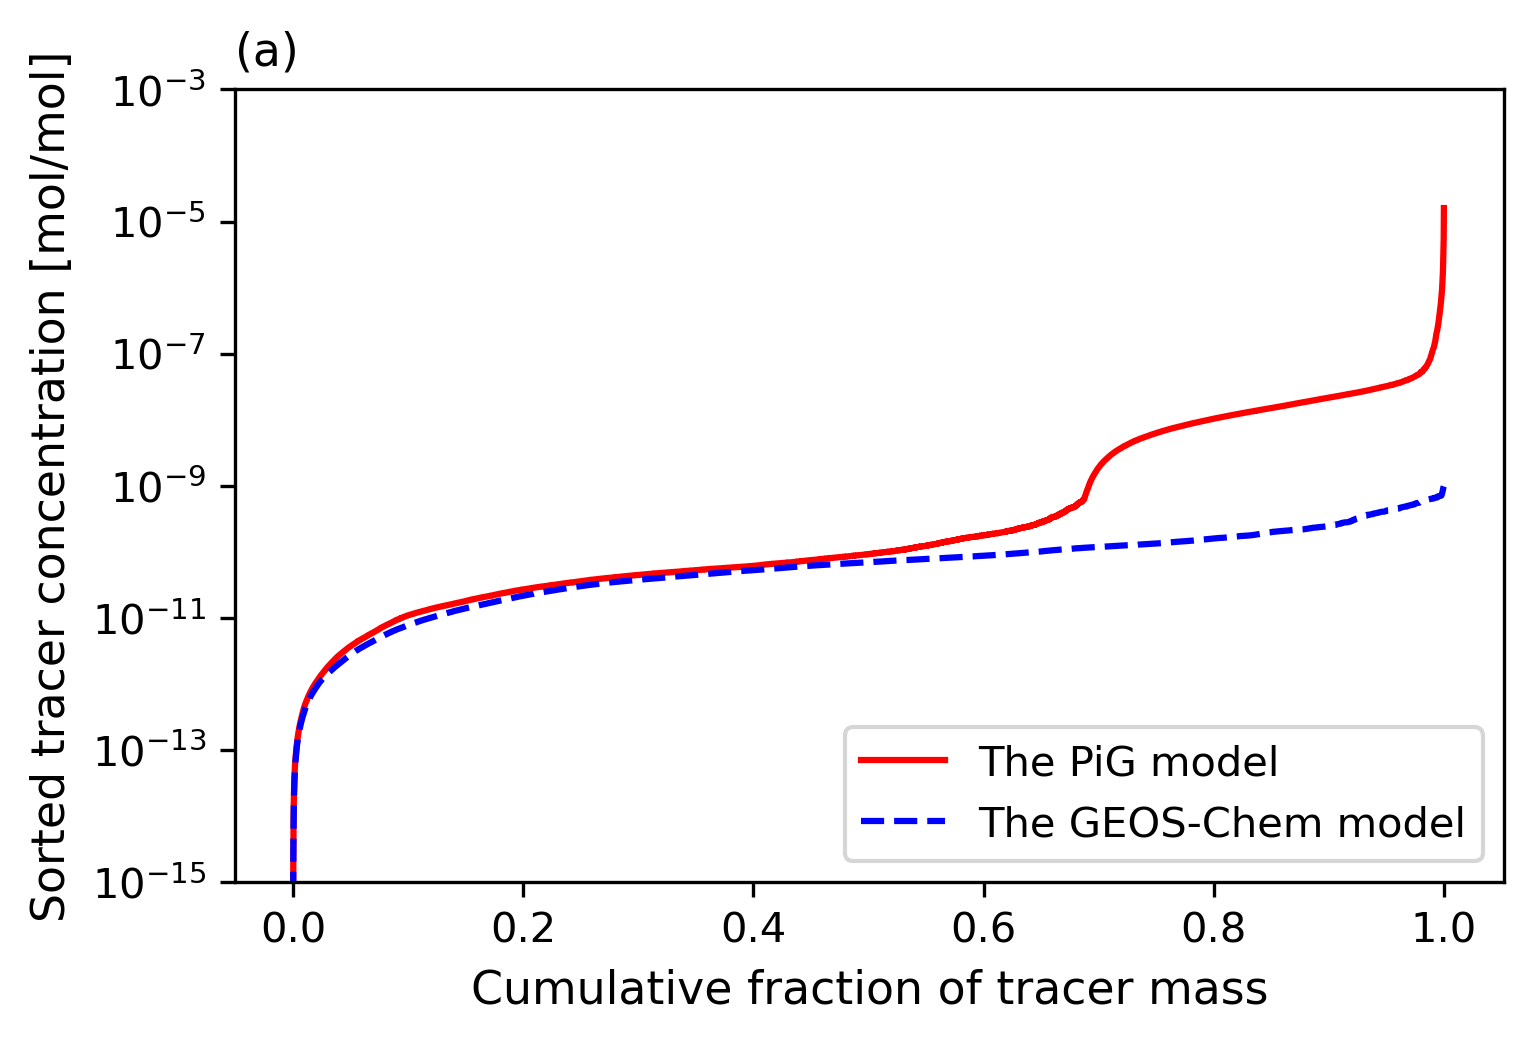

In [20]:
Nt1 = 1
Nt2 = 31

days = np.arange(Nt1,Nt2,1)

fig = plt.figure(figsize=(12,3.5), dpi=300)

# first
ax1 = fig.add_subplot(1,2,1)

# ax1.plot(PG_tracer_cumsum_new, PG_mixing_new, 'b--', alpha=a, label='PiG (post-process with dilution)')
ax1.plot(LA_tracer_cumsum_new/LA_tracer_cumsum_new.values[-1], LA_mixing_new, 'r', label='The PiG model')
ax1.plot(EU_tracer_cumsum_new/EU_tracer_cumsum_new[-1], EU_mixing_new, 'b--', label='The GEOS-Chem model')


ax1.set_xlabel('Cumulative fraction of tracer mass', fontsize=11)
ax1.set_ylabel('Sorted tracer concentration [mol/mol]', fontsize=11)
ax1.set_title('(a)', loc='left', fontsize=11)

# plt.xlim(1, 1e8)
ax1.set_ylim(1e-15, 1e-3)

ax1.set_yscale('log')
# plt.xscale('log')

ax1.legend(loc='lower right');


In [21]:
LA_tracer_cumsum_new.values[-1]

157975790.0

<ipython-input-21-115486ff67e2>:31: RuntimeWarning: divide by zero encountered in log
  plt.scatter(EU_tracer_mol_cumsum, np.log(EU_mixing_ratio_sorted), c='m', s=3, alpha=a)
/n/home12/hongwei/.conda/envs/SUNenv/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


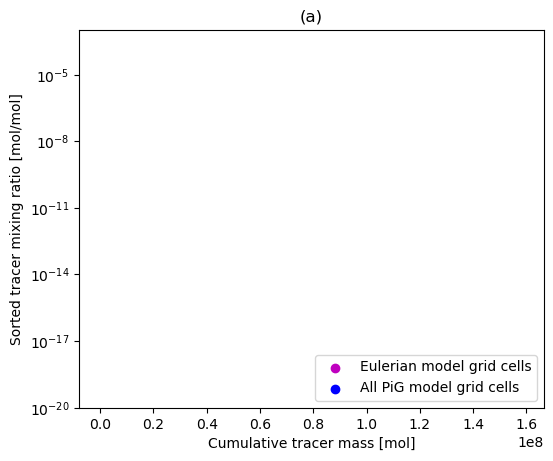

In [21]:

EU_index = EU_mixing_ratio.argsort()
EU_mixing_ratio_sorted = EU_mixing_ratio[EU_index]
EU_tracer_mol_sorted = EU_tracer_mol[EU_index]
EU_tracer_mol_cumsum = np.cumsum(EU_tracer_mol_sorted)


LA_index = LA_mixing_ratio.argsort()
LA_mixing_ratio_sorted = LA_mixing_ratio[LA_index]
LA_tracer_mol_sorted = LA_tracer_mol[LA_index]
LA_tracer_mol_cumsum = np.cumsum(LA_tracer_mol_sorted)
LA_type_sorted = LA_type[LA_index]


LA_type_1 = LA_type[LA_index]
LA_type_1[LA_type_1==2] = 0

LA_type_2 = LA_type[LA_index]
LA_type_2[LA_type_2==1] = 0
LA_type_2 = LA_type_2/2

LA_type_0 = LA_type[LA_index]+1
LA_type_0[LA_type_0>1] = 0



figure = plt.figure(figsize=(6,5), dpi=100)

a = 0.5


plt.scatter(EU_tracer_mol_cumsum, np.log(EU_mixing_ratio_sorted), c='m', s=3, alpha=a)
plt.scatter(0,0, c='m', label='Eulerian model grid cells')


plt.scatter(LA_tracer_mol_cumsum, np.log(LA_mixing_ratio_sorted), c='b', s=1, alpha=a)
plt.scatter(0,0, c='b', label='All PiG model grid cells')


plt.xlabel('Cumulative tracer mass [mol]')
plt.ylabel('Sorted tracer mixing ratio [mol/mol]')
plt.title('(a)')

# plt.xlim(1, 1e8)
plt.ylim(1e-20, 1e-3)

plt.yscale('log')
# plt.xscale('log')

plt.legend(loc='lower right');

In [22]:
Entropy3d_EU3[Nt1-1:Nt2-1]

array([1.64397720e-15, 3.27124281e-15, 4.92497777e-15, 6.56330050e-15,
       8.23520944e-15, 9.90489345e-15, 1.15895468e-14, 1.32848618e-14,
       1.49935000e-14, 1.67185999e-14, 1.84354734e-14, 2.02010217e-14,
       2.19281734e-14, 2.36800893e-14, 2.54103443e-14, 2.71518936e-14,
       2.88898943e-14, 3.06345840e-14, 3.23959899e-14, 3.41409147e-14,
       3.59209083e-14, 3.76614221e-14, 3.94508669e-14, 4.12239330e-14,
       4.29966951e-14, 4.47531705e-14, 4.65112858e-14, 4.82905019e-14,
       5.00281351e-14, 5.17750674e-14])

In [23]:
Entropy3d_LA1[Nt1:Nt2]

array([1.31522502e-15, 2.75727804e-15, 4.15823443e-15, 5.71687452e-15,
       7.27829332e-15, 8.69724483e-15, 1.02937364e-14, 1.19824271e-14,
       1.35372348e-14, 1.50478986e-14, 1.65290847e-14, 1.81101350e-14,
       1.98973623e-14, 2.15657346e-14, 2.32626598e-14, 2.48639820e-14,
       2.64972456e-14, 2.81146894e-14, 2.98171575e-14, 3.15608014e-14,
       3.30877797e-14, 3.47181936e-14, 3.65567848e-14, 3.82438204e-14,
       3.97774755e-14, 4.15686428e-14, 4.32190756e-14, 4.51071357e-14,
       4.67165070e-14, 4.82821734e-14])

In [24]:
print(Percent1[-1], Percent2[-1], (Percent1[-1]-Percent2[-1])/Percent1[-1])

-2.2850852270012187 -6.746285731758708 -1.9523125229828067


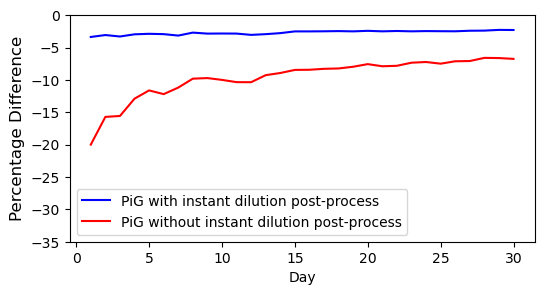

In [25]:

figure = plt.figure(figsize=(6,3), dpi=100)

Entropy3d_EU3 = np.array(Entropy3d_EU3)
Entropy3d_LA0 = np.array(Entropy3d_LA0)
Entropy3d_LA1 = np.array(Entropy3d_LA1)

Percent1 = 100*(Entropy3d_LA0[Nt1-1:Nt2-1]-Entropy3d_EU3[Nt1-1:Nt2-1])/Entropy3d_EU3[Nt1-1:Nt2-1]
Percent2 = 100*(Entropy3d_LA1[Nt1:Nt2]-Entropy3d_EU3[Nt1-1:Nt2-1])/Entropy3d_EU3[Nt1-1:Nt2-1]

plt.plot(days, Percent1,'b', label='PiG with instant dilution post-process')
plt.plot(days, Percent2,'r', label='PiG without instant dilution post-process')

# plt.yscale('log')

plt.ylim(-35,0)

plt.ylabel('Percentage Difference', fontsize=12)
plt.xlabel('Day')
plt.legend();

# the percentage keep decreasing because more injected tracer are simulated by the Eulerian grid
# the propotion of injected tracer simulated by the plume model keeps decreasing

In [26]:
Percent1

array([-3.35956536, -3.06368386, -3.28823017, -2.95082111, -2.87147838,
       -2.92358059, -3.14594618, -2.68721633, -2.84078198, -2.82596668,
       -2.83781111, -3.03730479, -2.9263765 , -2.76699673, -2.49940485,
       -2.49934734, -2.48362583, -2.45376986, -2.49462401, -2.41242789,
       -2.49057124, -2.43634948, -2.48953213, -2.4513207 , -2.47010438,
       -2.48231137, -2.39792634, -2.3786627 , -2.26605363, -2.28508523])

In [27]:
Percent2

array([-19.99736852, -15.71160548, -15.5684631 , -12.89634661,
       -11.61981523, -12.1924443 , -11.18085426,  -9.80390096,
        -9.71264356,  -9.99306972, -10.34087211, -10.35040069,
        -9.26119599,  -8.92882904,  -8.45200867,  -8.42634272,
        -8.2819573 ,  -8.2256532 ,  -7.96034474,  -7.5572472 ,
        -7.88712976,  -7.81496912,  -7.33591498,  -7.22908361,
        -7.4871327 ,  -7.11575897,  -7.07830398,  -6.59211663,
        -6.61953121,  -6.74628573])

In [28]:
print(Entropy3d_EU3)
print(Entropy3d_LA0)
print(Entropy3d_LA1)

[1.64397720e-15 3.27124281e-15 4.92497777e-15 6.56330050e-15
 8.23520944e-15 9.90489345e-15 1.15895468e-14 1.32848618e-14
 1.49935000e-14 1.67185999e-14 1.84354734e-14 2.02010217e-14
 2.19281734e-14 2.36800893e-14 2.54103443e-14 2.71518936e-14
 2.88898943e-14 3.06345840e-14 3.23959899e-14 3.41409147e-14
 3.59209083e-14 3.76614221e-14 3.94508669e-14 4.12239330e-14
 4.29966951e-14 4.47531705e-14 4.65112858e-14 4.82905019e-14
 5.00281351e-14 5.17750674e-14]
[1.58874671e-15 3.17102227e-15 4.76303317e-15 6.36962924e-15
 7.99873719e-15 9.61531590e-15 1.12249459e-14 1.29278688e-14
 1.45675673e-14 1.62461379e-14 1.79123095e-14 1.95874551e-14
 2.12864725e-14 2.30248620e-14 2.47752369e-14 2.64732735e-14
 2.81723774e-14 2.98828818e-14 3.15878318e-14 3.33172897e-14
 3.50262725e-14 3.67438582e-14 3.84687249e-14 4.02134022e-14
 4.19346319e-14 4.36422575e-14 4.53959795e-14 4.71418338e-14
 4.88944707e-14 5.05919630e-14]
[8.19478394e-18 1.31522502e-15 2.75727804e-15 4.15823443e-15
 5.71687452e-15 7.278

In [29]:
type(EU_mixing_ratio[0,0,0])

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
np.min(EU_mixing_ratio)

In [ ]:
df.dtypes

In [ ]:
plt.plot(LA_type)

In [ ]:
type(LA_tracer_mol)

In [ ]:
df1 = df[df['Type']==1]
df2 = df[df['Type']==2]
df0 = df[df['Type']==0]

LA1_tracer_mol   = df1["tracer_mol"].astype('float32')
LA1_mixing_ratio = df1['mixing_ratio'].astype('float32')

LA2_tracer_mol   = df2["tracer_mol"].astype('float32')
LA2_mixing_ratio = df2['mixing_ratio'].astype('float32')

LA0_tracer_mol   = df0["tracer_mol"].astype('float32')
LA0_mixing_ratio = df0['mixing_ratio'].astype('float32')

LA1_air_mass = LA1_tracer_mol/LA1_mixing_ratio
LA2_air_mass = LA2_tracer_mol/LA2_mixing_ratio
LA0_air_mass = LA0_tracer_mol/LA0_mixing_ratio
EU_air_mass  = EU_tracer_mol /EU_mixing_ratio


In [ ]:
figure = plt.figure(figsize=(6,5), dpi=100)

a = 8e-3

plt.scatter(LA1_air_mass, LA1_mixing_ratio, c='r', s=1.5, alpha=a)
plt.scatter(LA2_air_mass, LA2_mixing_ratio, c='y', s=1.5, alpha=a)
plt.scatter(LA0_air_mass, LA0_mixing_ratio, c='b', s=1.5, alpha=a)

plt.scatter(0,0, c='r', label='Plume model grid cells (1-D)')
plt.scatter(0,0, c='y', label='Plume model grid cells (2-D)')
plt.scatter(0,0, c='b', label='Host eulerian grid cells')
# plt.plot(EU_tracer_mol.reshape(-1)/EU_mixing_ratio.reshape(-1), EU_mixing_ratio.reshape(-1), 'b.', alpha=0.01)

plt.xlabel('Grid cell: air mass [mol]')
plt.ylabel('Grid cell: tracer mixing ratio [mol/mol]')
plt.title('(a) the PiG model')

plt.xlim(1e7, 1e16)
plt.ylim(1e-61, 1e-1)

plt.yscale('log')
plt.xscale('log')

plt.legend(loc='lower left');

In [ ]:
figure = plt.figure(figsize=(6,5), dpi=100)

a = 8e-3

# plt.scatter(LA_tracer_mol/LA_mixing_ratio, LA_mixing_ratio, c='b', alpha=a)
# plt.scatter(LA2_tracer_mol/LA2_mixing_ratio, LA2_mixing_ratio, c='y', alpha=a)
# plt.scatter(LA0_tracer_mol/LA0_mixing_ratio, LA0_mixing_ratio, c='b', alpha=a)
plt.scatter(EU_air_mass, EU_mixing_ratio, c='m', s=1.5, alpha=a)
plt.scatter(0,0, c='m', label='Eulerian grid cells')
# plt.scatter(0,0, c='r', label='Plume model grid cell (1-D)')
# plt.scatter(0,0, c='y', label='Plume model grid cell (2-D)')
# plt.scatter(0,0, c='b', label='Eulerian grid cell')
# plt.plot(EU_tracer_mol.reshape(-1)/EU_mixing_ratio.reshape(-1), EU_mixing_ratio.reshape(-1), 'b.', alpha=0.01)

plt.xlabel('Grid cell: air mass [mol]')
plt.ylabel('Grid cell: tracer mixing ratio [mol/mol]')
plt.title('(b) the GEOS-Chem model')

plt.xlim(1e7, 1e16)
plt.ylim(1e-61, 1e-1)

plt.yscale('log')
plt.xscale('log')

plt.legend(loc='lower left');

In [ ]:
EU_index = EU_mixing_ratio.argsort()
EU_mixing_ratio_sorted = EU_mixing_ratio[EU_index]
EU_tracer_mol_sorted = EU_tracer_mol[EU_index]
EU_tracer_mol_cumsum = np.cumsum(EU_tracer_mol_sorted)


LA_index = LA_mixing_ratio.argsort()
LA_mixing_ratio_sorted = LA_mixing_ratio[LA_index]
LA_tracer_mol_sorted = LA_tracer_mol[LA_index]
LA_tracer_mol_cumsum = np.cumsum(LA_tracer_mol_sorted)
LA_type_sorted = LA_type[LA_index]

EU_num1 = -2500
EU_mixing_new = EU_mixing_ratio_sorted[EU_num1:-1]
EU_tracer_new = EU_tracer_mol_sorted[EU_num1:-1]
EU_tracer_cumsum_new = EU_tracer_mol_cumsum[EU_num1:-1]


LA_num1 = -2500000
LA_mixing_new = LA_mixing_ratio_sorted[LA_num1:-1]
LA_tracer_new = LA_tracer_mol_sorted[LA_num1:-1]
LA_tracer_cumsum_new = LA_tracer_mol_cumsum[LA_num1:-1]



figure = plt.figure(figsize=(6,5), dpi=100)

a = 0.5


plt.scatter(EU_tracer_cumsum_new, EU_mixing_new, c='m', s=3, alpha=a)
plt.scatter(0,0, c='m', label='Eulerian model grid cells')


plt.scatter(LA_tracer_cumsum_new, LA_mixing_new, c='b', s=1, alpha=a)
plt.scatter(0,0, c='b', label='All PiG model grid cells')


plt.xlabel('Cumulative tracer mass [mol]')
plt.ylabel('Sorted tracer mixing ratio [mol/mol]')
plt.title('(a)')

# plt.xlim(1, 1e8)
plt.ylim(1e-15, 1e-3)

plt.yscale('log')
# plt.xscale('log')

plt.legend(loc='lower right');

In [ ]:
EU_index = EU_mixing_ratio.argsort()
EU_mixing_ratio_sorted = EU_mixing_ratio[EU_index]
EU_tracer_mol_sorted = EU_tracer_mol[EU_index]
EU_tracer_mol_cumsum = np.cumsum(EU_tracer_mol_sorted)


PG_index = PG_mixing_ratio.argsort()
PG_mixing_ratio_sorted = PG_mixing_ratio[PG_index]
PG_tracer_mol_sorted = PG_tracer_mol[PG_index]
PG_tracer_mol_cumsum = np.cumsum(PG_tracer_mol_sorted)


LA_index = LA_mixing_ratio.argsort()
LA_mixing_ratio_sorted = LA_mixing_ratio[LA_index]
LA_tracer_mol_sorted = LA_tracer_mol[LA_index]
LA_tracer_mol_cumsum = np.cumsum(LA_tracer_mol_sorted)
LA_type_sorted = LA_type[LA_index]

# EU_num1 = -400
EU_mixing_new = EU_mixing_ratio_sorted[EU_num1:-1]
EU_tracer_new = EU_tracer_mol_sorted[EU_num1:-1]
EU_tracer_cumsum_new = EU_tracer_mol_cumsum[EU_num1:-1]


# LA_num1 = -1000000
LA_mixing_new = LA_mixing_ratio_sorted[LA_num1:-1]
LA_tracer_new = LA_tracer_mol_sorted[LA_num1:-1]
LA_tracer_cumsum_new = LA_tracer_mol_cumsum[LA_num1:-1]



figure = plt.figure(figsize=(6,5), dpi=100)

a = 0.5


plt.scatter(EU_tracer_cumsum_new, np.log(EU_mixing_new), c='m', s=3, alpha=a)
plt.scatter(0,0, c='m', label='Eulerian model grid cells')


plt.scatter(LA_tracer_cumsum_new, np.log(LA_mixing_new), c='b', s=1, alpha=a)
plt.scatter(0,0, c='b', label='All PiG model grid cells')


plt.xlabel('Cumulative tracer mass [mol]')
plt.ylabel('Natural log for Sorted tracer mixing ratio')
plt.title('(b)')

# plt.xlim(1, 1e8)
plt.ylim(-35, -5)

# plt.yscale('log')
# plt.xscale('log')

plt.legend(loc='lower right');

In [ ]:
np.min(np.log(EU_mixing_new)),np.min(np.log(LA_mixing_new))

In [ ]:
np.max(np.log(EU_mixing_new)),np.max(np.log(LA_mixing_new))

In [ ]:
np.log(1e-15)

In [ ]:
-k*np.sum(EU_tracer_new*np.log(EU_mixing_new))

In [ ]:
-k*np.sum(LA_tracer_new*np.log(LA_mixing_new))

In [ ]:
-k*np.sum(EU_tracer_mol_sorted*np.log(EU_mixing_ratio_sorted,where=(EU_mixing_ratio_sorted!=0)))

In [38]:
-k*np.sum(LA_tracer_mol_sorted*np.log(LA_mixing_ratio_sorted, where=(LA_mixing_ratio_sorted!=0)))

1.31522545603408e-15

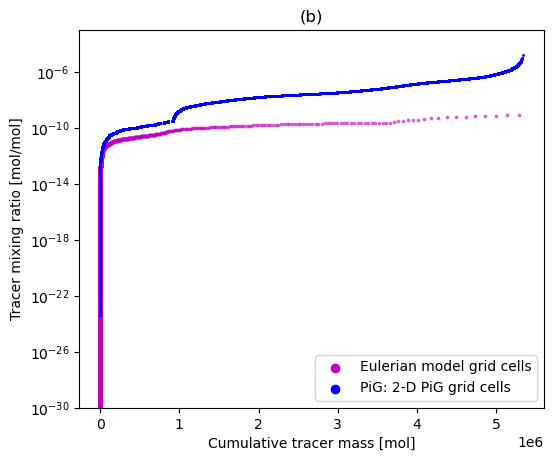

In [39]:
figure = plt.figure(figsize=(6,5), dpi=100)

a = 0.5

plt.scatter(EU_tracer_mol_cumsum, EU_mixing_ratio_sorted, c='m', s=3, alpha=a)
plt.scatter(0,0, c='m', label='Eulerian model grid cells')

plt.scatter(LA_type_2*LA_tracer_mol_cumsum, LA_type_2*LA_mixing_ratio_sorted, c='b', s=1, alpha=a)
plt.scatter(0,0, c='b', label='PiG: 2-D PiG grid cells')

# plt.scatter(LA_type_1*LA_tracer_mol_cumsum, LA_type_1*LA_mixing_ratio_sorted, c='y', s=1.5, alpha=a)
# plt.scatter(0,0, c='y', label='1-D PiG grid cells')

# plt.scatter(LA_type_0*LA_tracer_mol_cumsum, LA_type_0*LA_mixing_ratio_sorted, c='r', s=1, alpha=a)
# plt.scatter(0,0, c='r', label='PiG grid cells')


plt.xlabel('Cumulative tracer mass [mol]')
plt.ylabel('Tracer mixing ratio [mol/mol]')
plt.title('(b)')

# plt.xlim(1, 1e8)
plt.ylim(1e-30, 1e-3)

plt.yscale('log')
# plt.xscale('log')

plt.legend(loc='lower right');

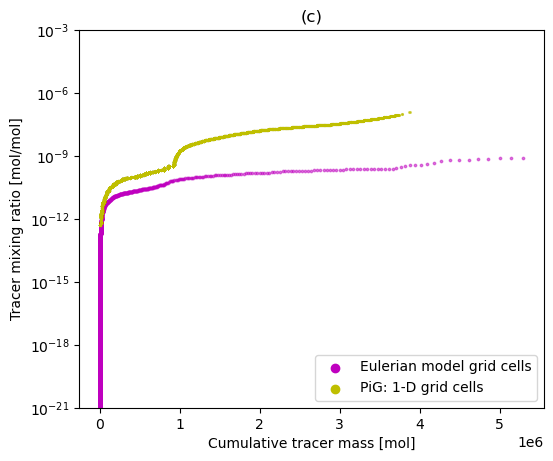

In [40]:
figure = plt.figure(figsize=(6,5), dpi=100)

a = 0.5

plt.scatter(EU_tracer_mol_cumsum, EU_mixing_ratio_sorted, c='m', s=3, alpha=a)
plt.scatter(0,0, c='m', label='Eulerian model grid cells')

# plt.scatter(LA_type_2*LA_tracer_mol_cumsum, LA_type_2*LA_mixing_ratio_sorted, c='b', s=1, alpha=a)
# plt.scatter(0,0, c='b', label='PiG: 2-D PiG grid cells')

plt.scatter(LA_type_1*LA_tracer_mol_cumsum, LA_type_1*LA_mixing_ratio_sorted, c='y', s=1.5, alpha=a)
plt.scatter(0,0, c='y', label='PiG: 1-D grid cells')

# plt.scatter(LA_type_0*LA_tracer_mol_cumsum, LA_type_0*LA_mixing_ratio_sorted, c='r', s=1, alpha=a)
# plt.scatter(0,0, c='r', label='PiG grid cells')


plt.xlabel('Cumulative tracer mass [mol]')
plt.ylabel('Tracer mixing ratio [mol/mol]')
plt.title('(c)')

# plt.xlim(1, 1e8)
plt.ylim(1e-21, 1e-3)

plt.yscale('log')
# plt.xscale('log')

plt.legend(loc='lower right');

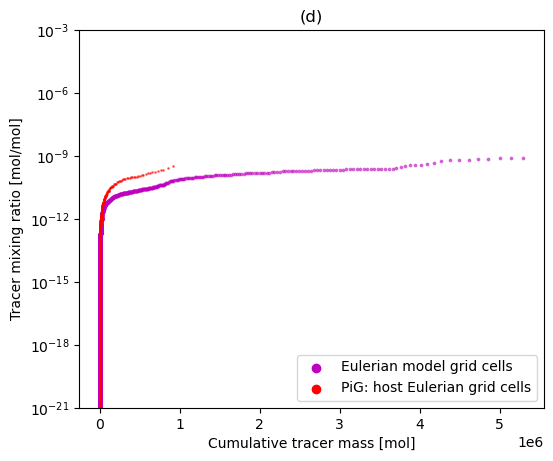

In [41]:
figure = plt.figure(figsize=(6,5), dpi=100)

a = 0.5

plt.scatter(EU_tracer_mol_cumsum, EU_mixing_ratio_sorted, c='m', s=3, alpha=a)
plt.scatter(0,0, c='m', label='Eulerian model grid cells')

# plt.scatter(LA_type_2*LA_tracer_mol_cumsum, LA_type_2*LA_mixing_ratio_sorted, c='b', s=1, alpha=a)
# plt.scatter(0,0, c='b', label='PiG: 2-D PiG grid cells')

# plt.scatter(LA_type_1*LA_tracer_mol_cumsum, LA_type_1*LA_mixing_ratio_sorted, c='y', s=1.5, alpha=a)
# plt.scatter(0,0, c='y', label='1-D PiG grid cells')

plt.scatter(LA_type_0*LA_tracer_mol_cumsum, LA_type_0*LA_mixing_ratio_sorted, c='r', s=1, alpha=a)
plt.scatter(0,0, c='r', label='PiG: host Eulerian grid cells')


plt.xlabel('Cumulative tracer mass [mol]')
plt.ylabel('Tracer mixing ratio [mol/mol]')
plt.title('(d)')

# plt.xlim(1, 1e8)
plt.ylim(1e-21, 1e-3)

plt.yscale('log')
# plt.xscale('log')

plt.legend(loc='lower right');

In [42]:
np.sum(LA_tracer_mol_sorted), np.sum( np.log(LA_mixing_ratio_sorted, where=(LA_mixing_ratio_sorted!=0)) )


(5338156.0, -103458296.0)

In [157]:
np.sum(EU_tracer_mol_sorted), np.sum( np.log(EU_mixing_ratio_sorted, where=(EU_mixing_ratio_sorted!=0)) )

(5288779.5, -23819678.0)

In [191]:
np.log(1/100), np.log(1/40), np.log(1/10)

(-4.605170185988091, -3.6888794541139363, -2.3025850929940455)

In [194]:
(np.log(1/100)-np.log(1/33)) /np.log(1/100)

0.24074303006105618

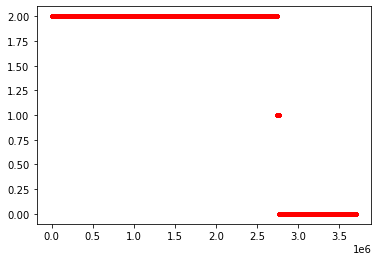

In [139]:
plt.plot(LA_type_sorted,'r.')
# plt.plot(LA_type,'b.')

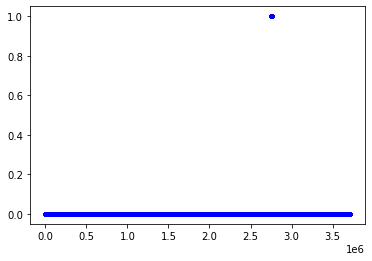

In [142]:
plt.plot(LA_type_1,'b.')


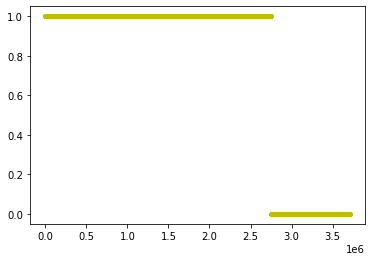

In [143]:
plt.plot(LA_type_2,'y.')


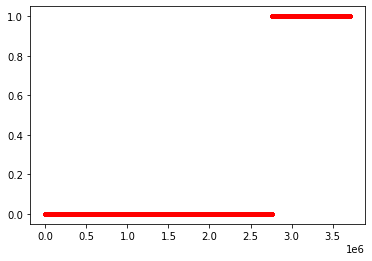

In [144]:
plt.plot(LA_type_0,'r.')

In [120]:
print(np.sum(LA_type_1), np.sum(LA_type_2), np.sum(LA_type_0), np.sum(LA_type))

0 0 3709992 5516292


In [81]:
len(EU_mixing_ratio), EU_mixing_ratio_sorted[0], EU_mixing_ratio_sorted[-1]

(943488, 0.0, 8.08428e-10)

In [27]:
np.sum(LA_tracer_mol), np.sum(EU_tracer_mol)

(5338155.5, 5288780.5)

In [28]:
np.sum(LA_air_mass), np.sum(EU_air_mass)

(inf, 3.0351953e+19)

In [29]:
np.sum(LA1_air_mass), np.sum(LA2_air_mass), np.sum(LA0_air_mass)

(1521546300000000.0, 338955900000000.0, inf)

In [30]:
np.min(LA0_air_mass), np.max(LA0_air_mass)

(949646660.0, inf)

In [31]:
ss = sorted(LA0_air_mass)
ss[-10:-1]

[inf, inf, inf, inf, inf, inf, inf, inf, inf]

In [32]:
np.sum(LA1_tracer_mol), np.sum(LA2_tracer_mol), np.sum(LA0_tracer_mol)

(2508287.0, 2013484.2, 816385.06)

In [35]:
all = np.sum(LA1_tracer_mol)+np.sum(LA2_tracer_mol)+np.sum(LA0_tracer_mol)
np.sum(LA1_tracer_mol)/all, np.sum(LA2_tracer_mol)/all, np.sum(LA0_tracer_mol)/all

(0.4698789, 0.37718722, 0.15293391)

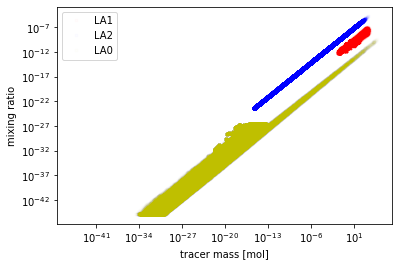

In [64]:


plt.plot(LA1_tracer_mol, LA1_mixing_ratio, 'r.', alpha=0.01, label='LA1')
plt.plot(LA2_tracer_mol, LA2_mixing_ratio, 'b.', alpha=0.01, label='LA2')
plt.plot(LA0_tracer_mol, LA0_mixing_ratio, 'y.', alpha=0.01, label='LA0')
# plt.plot(EU_tracer_mol.reshape(-1), EU_mixing_ratio.reshape(-1), 'b.', alpha=0.01, label='EU')


plt.yscale('log')
plt.xscale('log')


plt.xlabel('tracer mass [mol]')
plt.ylabel('mixing ratio')
plt.legend()

# np.sum(LA_tracer_mol), np.sum(EU_tracer_mol)

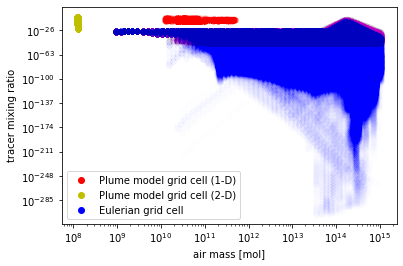

In [42]:
a = 5e-3

plt.scatter(LA1_tracer_mol/LA1_mixing_ratio, LA1_mixing_ratio, c='r', alpha=a)
plt.scatter(LA2_tracer_mol/LA2_mixing_ratio, LA2_mixing_ratio, c='y', alpha=a)
plt.scatter(LA0_tracer_mol/LA0_mixing_ratio, LA0_mixing_ratio, c='b', alpha=a)
plt.scatter(EU_tracer_mol.reshape(-1)/EU_mixing_ratio.reshape(-1), EU_mixing_ratio.reshape(-1), c='m', alpha=a)

plt.scatter(0,0, c='r', label='Plume model grid cell (1-D)')
plt.scatter(0,0, c='y', label='Plume model grid cell (2-D)')
plt.scatter(0,0, c='b', label='Eulerian grid cell')
# plt.plot(EU_tracer_mol.reshape(-1)/EU_mixing_ratio.reshape(-1), EU_mixing_ratio.reshape(-1), 'b.', alpha=0.01)

plt.xlabel('air mass [mol]')
plt.ylabel('tracer mixing ratio')

plt.yscale('log')
plt.xscale('log')

plt.legend()

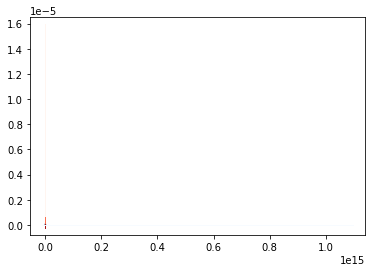

In [37]:
plt.hexbin(LA1_tracer_mol/LA1_mixing_ratio, LA1_mixing_ratio, bins='log', gridsize=(50,20),  cmap='Blues')
plt.hexbin(LA2_tracer_mol/LA2_mixing_ratio, LA2_mixing_ratio, bins='log', gridsize=(50,20),  cmap='Reds')
plt.hexbin(LA0_tracer_mol/LA0_mixing_ratio, LA0_mixing_ratio, bins='log', gridsize=(50,20),  cmap='Blues')

In [ ]:
# df1['Concnt'].astype('float')
df1['Concnt'] = pd.to_numeric(df1['Concnt'], errors='coerce')
df1['Concnt'][0:243*117]

In [ ]:
df2 = df1[ df1['Concnt'] != 0 ] 
df2

In [ ]:
len(df1), len(df2)

In [ ]:
df1["Volume"]

In [ ]:
df1[0:243*117]

In [ ]:
df1.shape

In [ ]:
 len(df1)

In [ ]:
df1[0:1]['i_lon']

In [ ]:
df1['Volume'].sum()

In [ ]:
plt.plot(df1['Concnt'][0:243*117],'.');

In [ ]:
c = df1['Concnt'][0:243*117]
v = df1['Volume'][0:243*117]
np.sum(c*v)/NA, np.sum(c*v)/NA*98/1000 # [kg]

In [ ]:
c = df1['Concnt']
v = df1['Volume']
np.sum(c*v)/NA*98/1000 # [kg]

In [ ]:
# np.sum(EU3_mol[0,:,:,:])*98/1000 # [kg]

In [ ]:
df1 = pd.DataFrame(C1d_center)
df1.to_csv('C1d_center_time_series_10min.txt', index = False)

In [ ]:
d = {'col1': df1['Concnt'], 'col2': df1['Volume']}
df0 = pd.DataFrame(data=d)
df0.to_csv('All_Grid_Cell_GEOS-Chem_Plume.txt', index = False)

In [ ]:
df0

In [ ]:
Dir = '/n/home12/hongwei/HONGWEI/GC_Python/Paper1_plot'
file1_name = Dir+'/Gini_All_Grid_Cell_GEOS-Chem_Plume2015-1-2-0:0:0.csv'
    
    
df1 = pd.read_csv(file1_name, sep=",")
df1

In [ ]:
LA1_C_1D = df1['Concnt_mol_cm3'].values

LA1_C_1D[1:-1].shape

In [ ]:
LA1_C_1D = df1['Concnt_mol_cm3'].values
LA1_index = LA1_C_1D.argsort()
LA1_C_sorted = LA1_C_1D[LA1_index]
LA1_C_sorted

In [ ]:
df1['Mass_mol'].min(), df1['Mass_mol'].max(), df1['Mass_mol'].sum()

In [ ]:
df1['Volume_cm3'].min(), df1['Volume_cm3'].max()

In [ ]:
np.sum(df1['Mass_mol'])